In [1]:
%matplotlib inline
from vnpy.trader.vtObject import VtBarData
from vnpy.trader.vtConstant import EMPTY_STRING, EMPTY_FLOAT
from vnpy.trader.app.ctaStrategy.ctaBase import TICK_DB_NAME
from datetime import datetime, time
from vnpy.trader.app.ctaStrategy.ctaBacktesting import BacktestingEngine
from vnpy.trader.app.ctaStrategy.ctaTemplate import (CtaTemplate, 
                                                     BarManager, 
                                                     ArrayManager)
import threading

In [2]:
'''
我的策略
'''
class SimpleStrategy(CtaTemplate):
    """根据夜盘收盘前的价格趋势开仓入场，移动百分比离场"""
    className = 'SimpleStrategy'
    author = u'loe'

    # 策略参数
    tradeSize = 1 # 交易数量
    #startTime = time(22, 58, 26) # 趋势判断开始时间
    #endTime =  time(22, 59, 56) # 趋势判断截至时间
    startTime = time(23, 28, 26) # 趋势判断开始时间
    endTime =  time(23, 29, 56) # 趋势判断截至时间
    outPercent = 0.1 # 移动止盈止损百分比

    # 策略变量
    todayDate = None # 当前日期
    todayEntry = False # 当天是否已经产生信号
    startPrice = EMPTY_FLOAT # 趋势判断开始价格
    endPrice = EMPTY_FLOAT # 趋势判断截至价格
    highPrice = EMPTY_FLOAT # 持仓后的最高价，为了多头止盈止损的计算
    lowPrice = EMPTY_FLOAT # 持仓后的最低价， 为了空头止盈止损的计算

    # 参数列表，保存了参数的名称
    paramList = ['name',
                 'className',
                 'author',
                 'vtSymbol',
                 'tradeSize',
                 'startTime',
                 'endTime',
                 'outPercent']    

    # 变量列表，保存了变量的名称
    varList = ['inited',
               'trading',
               'pos',
               'todayDate',
               'todayEntry',
               'startPrice',
               'endPrice',
               'highPrice',
               'lowPrice']
    
    # 同步列表
    syncList = ['pos',
                'highPrice',
                'lowPrice']
    
    #测试------
    entryPrice = EMPTY_FLOAT
    outPrice = EMPTY_FLOAT
    totalEarning = EMPTY_FLOAT
    

    #----------------------------------------------------------------------
    def __init__(self, ctaEngine, setting):
        """Constructor"""
        super(SimpleStrategy, self).__init__(ctaEngine, setting)        

    #----------------------------------------------------------------------
    def onInit(self):
        """初始化策略（必须由用户继承实现）"""
        self.writeCtaLog(u'%s策略初始化' %self.name)
        self.putEvent()

    #----------------------------------------------------------------------
    def onStart(self):
        """启动策略（必须由用户继承实现）"""
        self.writeCtaLog(u'%s策略启动' %self.name)
        self.putEvent()

    #----------------------------------------------------------------------
    def onStop(self):
        """停止策略（必须由用户继承实现）"""
        self.writeCtaLog(u'%s策略停止' %self.name)
        self.putEvent()

    #----------------------------------------------------------------------
    def onTick(self, tick):
        """收到行情TICK推送（必须由用户继承实现）"""
        '''
        if (tick.datetime.time() >= self.endTime) or (tick.datetime.time() <= time(9, 0, 20)):
            print tick.datetime, ' '*2, tick.lastPrice, ' '*2, 'ask:', tick.askPrice1, 'bid:', tick.bidPrice1
        '''
        
        #撤销未成交的单
        self.cancelAll()
        
        if (not self.todayDate) or (self.todayDate != tick.datetime.date()):
            # 早盘第一个tick收到后信号初始化
            #print tick.datetime, '='*16
            self.todayDate = tick.datetime.date()
            self.todayEntry = False
            self.startPrice = EMPTY_FLOAT
            self.endPrice = EMPTY_FLOAT
        
        if self.pos == 0:
            self.highPrice = EMPTY_FLOAT
            self.lowPrice = EMPTY_FLOAT
            # 当前仓位为空才会做新的开仓信号判断
            if (self.startPrice == 0) and (tick.datetime.time() >= self.startTime) and (tick.datetime.time() < self.endTime):
                self.startPrice = tick.lastPrice
            
            if (self.endPrice == 0) and (tick.datetime.time() >= self.endTime):
                self.endPrice = tick.lastPrice
            
            if self.startPrice and self.endPrice and (not self.todayEntry):
                sub = self.endPrice - self.startPrice
                if sub > 0:
                    # 开仓多头
                    self.buy(tick.lastPrice + 10, self.tradeSize) # 限价单
                    #print u'委托多头开仓', tick.datetime, '*'*2, tick.lastPrice

                elif sub < 0:
                    # 开仓空头
                    self.short(tick.lastPrice - 10, self.tradeSize) # 限价单
                    #print u'委托空头开仓', tick.datetime, '*'*2, tick.lastPrice
        elif self.pos > 0:
            # 持有多头仓位
            '''
            print '='*20, tick.datetime, '='*20
            print 'tickPrice', '*'*2, tick.lastPrice
            print 'highPrice', '*'*2, self.highPrice
            '''
            if tick.lastPrice <= self.highPrice * (1 - self.outPercent/100):
                #止盈止损
                self.sell(tick.lastPrice -10, abs(self.pos)) # 限价单
                #print u'委托平仓', tick.datetime, '*'*2, tick.lastPrice
                #print u'止损'
        elif self.pos < 0:
            # 持有空头仓位
            '''
            print '='*20, tick.datetime, '='*20
            print 'tickPrice', '*'*2, tick.lastPrice
            print 'lowPrice', '*'*2, self.lowPrice
            '''
            if tick.lastPrice >= self.lowPrice * (1 + self.outPercent/100):
                #止盈止损
                self.cover(tick.lastPrice +10, abs(self.pos)) # 限价单
                #print u'委托平仓', tick.datetime, '*'*2, tick.lastPrice
                #print u'止损'
                
        if self.pos:
            self.highPrice = max(self.highPrice, tick.lastPrice)
            self.lowPrice = min(self.lowPrice, tick.lastPrice)

        # 发出状态更新事件
        self.putEvent()

    #----------------------------------------------------------------------
    def onBar(self, bar):
        """收到Bar推送（必须由用户继承实现）"""
        # 发出状态更新事件
        self.putEvent()

    #----------------------------------------------------------------------
    def onOrder(self, order):
        """收到委托变化推送（必须由用户继承实现）"""
        pass

    #----------------------------------------------------------------------
    def onTrade(self, trade):
        # 发出状态更新事件
        self.putEvent()
        if trade.offset == u'开仓':
            self.todayEntry = True
            self.highPrice = trade.price
            self.lowPrice = trade.price
        '''
        print '#'*20, 'T R A D E', '#'*20
        print trade.tradeTime
        print trade.direction
        print trade.offset
        print trade.price
        print self.pos, '\n'
        '''
        
        #测试------
        if trade.offset == u'开仓':
            self.entryPrice = trade.price
            #print u'开仓时间======', self.todayDate.strftime('%Y-%m-%d') + ' ' + trade.tradeTime
        elif trade.offset == u'平仓':
            self.outPrice = trade.price
            '''
            print u'平仓时间======', self.todayDate.strftime('%Y-%m-%d') + ' ' + trade.tradeTime
            print u'开仓价======', self.entryPrice
            print u'平仓价======', self.outPrice
            '''
            sub = self.outPrice - self.entryPrice
            if trade.direction == u'多':
                self.totalEarning -= sub
                '''
                print u'空'
                print '='*6, u'盈亏 ', -sub, '='*6
                print '='*6, u'累计盈亏 ', self.totalEarning, '='*6
                '''
            else:
                self.totalEarning += sub
                '''
                print u'多'
                print '='*6, u'盈亏 ', sub, '='*6
                print '='*6, u'累计盈亏 ', self.totalEarning, '='*6
                '''
            
            #print '\n'
            

    #----------------------------------------------------------------------
    def onStopOrder(self, so):
        """停止单推送"""
        pass

In [3]:
def runBacktesting(strategyClass, settingDict, symbol, 
                   startDate, endDate, slippage, 
                   rate, size, priceTick):
    """运行单标的回测"""
    #创建回测引擎实例
    engine = BacktestingEngine()
    
    #设置引擎的回测模式为K线
    engine.setBacktestingMode(engine.TICK_MODE)
    
    #设置使用的数据库
    engine.setDatabase(TICK_DB_NAME, symbol)

    #设置回测的起始日期
    engine.setStartDate(startDate, initDays = 0)
    
    #设置回测的截至日期
    engine.setEndDate(endDate)
    
    #滑点设置
    engine.setSlippage(slippage)
    
    #合约交易手续费
    engine.setRate(rate)   
    
    #合约每手数量
    engine.setSize(size)
    
    #合约最小价格变动
    engine.setPriceTick(priceTick)
    
    #引擎中创建策略对象
    engine.initStrategy(strategyClass, settingDict)
    
    #开始回测
    engine.runBacktesting()
    
    df = engine.calculateDailyResult()
    return df

In [6]:
class MyThread(threading.Thread):
    def __init__(self, func, args = ()):
        super(MyThread, self).__init__()
        self.func = func
        self.args = args
    
    def run(self):
        self.result = self.func(*self.args)
            
    def get_result(self):
        try:
            return self.result
        except Exception:
            return None

In [24]:
class multiRunbacktesting(object):
    def __init__(self, strategyClass, settingDict, symbol, 
                   startDate, endDate, slippage, 
                   rate, size, priceTick):
        super(multiRunbacktesting, self).__init__()
        self.strategyClass = strategyClass
        self.settingDict = settingDict
        self.symbol = symbol
        self.startDate = startDate
        self.endDate = endDate
        self.slippage = slippage
        self.rate = rate
        self.size = size
        self.priceTick = priceTick
    
    def run(self):
        dfList = []
        tList = []
        for i in range(1):
            start = ''
            end = ''
            if i == 0:
                start = '20170101'
                end = '20170105'
            elif i == 1:
                start = '20170101'
                end = '20170105'
            else:
                start = '20170110'
                end = '20170115'
    
            t = MyThread(runBacktesting, args = (self.strategyClass, self.settingDict, self.symbol, start, end, 
                                                 self.slippage, self.rate, self.size, self.priceTick))
            tList.append(t)
            t.start()
            print '&'*6, i, '&'*6
    
        for t in tList:
            t.join()
            dfList.append(t.get_result())
        print '='*20
        print len(dfList)

In [25]:
dfn = multiRunbacktesting(SimpleStrategy, {}, 'i00.TB', 
                     '20170101', '20170130', 0,
                     0.78/10000, 10, 0.5)
dfn.run()

&&&&&& 0 &&&&&&
2018-01-31 21:35:29.609000	开始载入数据
2018-01-31 21:35:29.764000	载入完成，数据量：117115
2018-01-31 21:35:29.764000	开始回测
2018-01-31 21:35:29.764000	策略初始化完成
2018-01-31 21:35:29.764000	策略启动完成
2018-01-31 21:35:29.764000	开始回放数据
2018-01-31 21:35:36.133000	数据回放结束
2018-01-31 21:35:36.134000	用时：6.370000s
2018-01-31 21:35:36.134000	计算按日统计结果
1


In [26]:
df1 = runBacktesting(SimpleStrategy, {}, 'i00.TB', 
                     '20170101', '20170105', 0,
                     0.78/10000, 10, 0.5)
df1

2018-01-31 21:35:42.184000	开始载入数据
2018-01-31 21:35:42.268000	载入完成，数据量：117115
2018-01-31 21:35:42.268000	开始回测
2018-01-31 21:35:42.268000	策略初始化完成
2018-01-31 21:35:42.268000	策略启动完成
2018-01-31 21:35:42.268000	开始回放数据
2018-01-31 21:35:48.961000	数据回放结束
2018-01-31 21:35:48.962000	用时：6.694000s
2018-01-31 21:35:48.962000	计算按日统计结果


,closePosition,closePrice,commission,netPnl,openPosition,positionPnl,previousClose,slippage,totalPnl,tradeCount,tradeList,tradingPnl,turnover
date,,,,,,,,,,,,,
2017-01-03,0,536.5,0.00000,0.00000,0,0.0,0.0,0,0.0,0,[],0.0,0.0
2017-01-04,0,546.5,0.85254,-10.85254,0,0.0,536.5,0,-10.0,2,[<vnpy.trader.vtObject.VtTradeData object at 0...,-10.0,10930.0
2017-01-05,0,552.0,0.00000,0.00000,0,0.0,546.5,0,0.0,0,[],0.0,0.0


In [ ]:
# 合并获得组合回测结果
#dfp = df1 + df2
dfp =  df1

# 注意如果被抛弃的交易日位于回测的前后，即两者不重合的日期中，则不会影响组合曲线正确性
# 但是如果被抛弃的交易日位于回测的中部，即两者重合的日期中，组合曲线会出现错误（丢失交易日）
dfp = dfp.dropna() 

# 创建回测引擎，并设置组合回测初始资金后，显示结果
engine = BacktestingEngine()
engine.setCapital(8000)
dfp, result = engine.calculateDailyStatistics(dfp)
engine.showDailyResult(dfp, result)


2018-01-31 21:35:56.654000	开始载入数据
2018-01-31 21:35:56.831000	载入完成，数据量：117115
2018-01-31 21:35:56.831000	开始回测
2018-01-31 21:35:56.831000	策略初始化完成
2018-01-31 21:35:56.831000	策略启动完成
2018-01-31 21:35:56.831000	开始回放数据
2018-01-31 21:36:03.686000	数据回放结束
2018-01-31 21:36:03.688000	用时：6.857000s
2018-01-31 21:36:03.690000	计算按日统计结果
2018-01-31 21:36:03.710000	------------------------------
2018-01-31 21:36:03.710000	首个交易日：	2017-01-03
2018-01-31 21:36:03.710000	最后交易日：	2017-01-05
2018-01-31 21:36:03.710000	总交易日：	3
2018-01-31 21:36:03.710000	盈利交易日	0
2018-01-31 21:36:03.710000	亏损交易日：	1
2018-01-31 21:36:03.711000	起始资金：	6000
2018-01-31 21:36:03.711000	结束资金：	5,968.91
2018-01-31 21:36:03.711000	总收益率：	-0.52
2018-01-31 21:36:03.711000	总盈亏：	-31.09
2018-01-31 21:36:03.711000	最大回撤: 	-31.09
2018-01-31 21:36:03.711000	总手续费：	1.09
2018-01-31 21:36:03.711000	总滑点：	20.0
2018-01-31 21:36:03.711000	总成交金额：	10,930.0
2018-01-31 21:36:03.711000	总成交笔数：	2.0
2018-01-31 21:36:03.711000	日均盈亏：	-10.36
2018-01-31 21:36:03.711000	日均

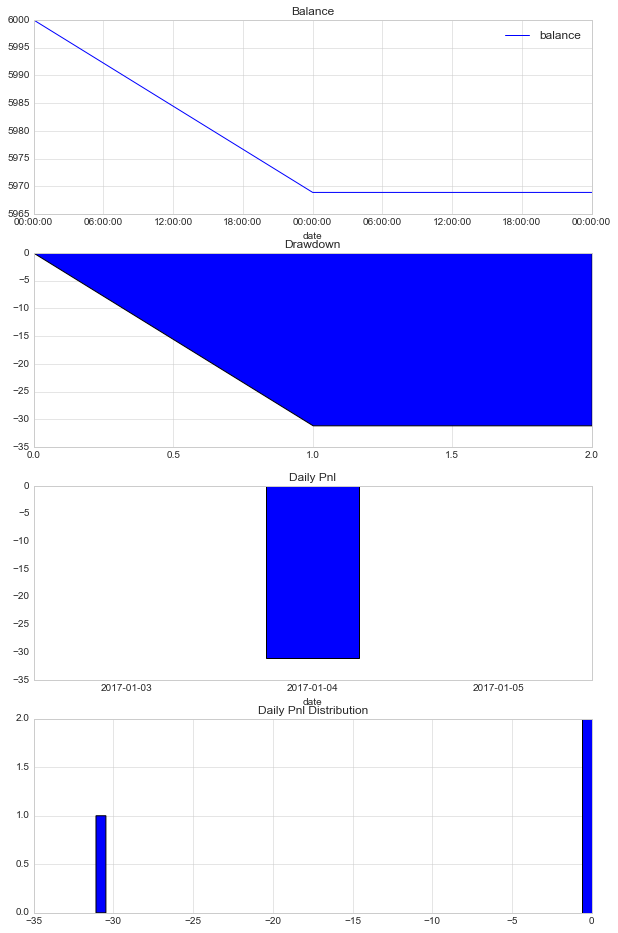

In [27]:
'''
回测
'''
#合约代码
code = 'i00'
exchange = 'TB'
vtCode = '.'.join([code, exchange])
startDate = '20170101'
endDate = '20170105'
#endDate = datetime.now().strftime('%Y%m%d')

#创建回测引擎实例
engine = BacktestingEngine()

#设置引擎的回测模式为K线
engine.setBacktestingMode(engine.TICK_MODE)

#设置回测的起始日期
engine.setStartDate(startDate, initDays = 0)

#设置回测的截至日期
engine.setEndDate(endDate)

#设置产品相关参数
engine.setSlippage(1)           #滑点设置
engine.setRate(1.0/10000)       #合约交易手续费万1
engine.setSize(10)               #合约每手数量
engine.setPriceTick(1)      #合约最小价格变动
engine.setCapital(6000) #初始资金

#设置使用的数据库
engine.setDatabase(TICK_DB_NAME, vtCode)

#引擎中创建策略对象
engine.initStrategy(SimpleStrategy, {})

#开始回测 
engine.runBacktesting()

#显示回测结果
engine.showDailyResult()